## AutoRegressive Model
* US population data
https://fred.stlouisfed.org/series/POPTHM

In [86]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

In [87]:
df = pd.read_csv('Data/POPTHM_NEW.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df.head()

,PopEst
DATE,
2011-01-01,311204.0
2011-02-01,311373.0
2011-03-01,311551.0
2011-04-01,311740.0
2011-05-01,311935.0


<Axes: xlabel='DATE'>

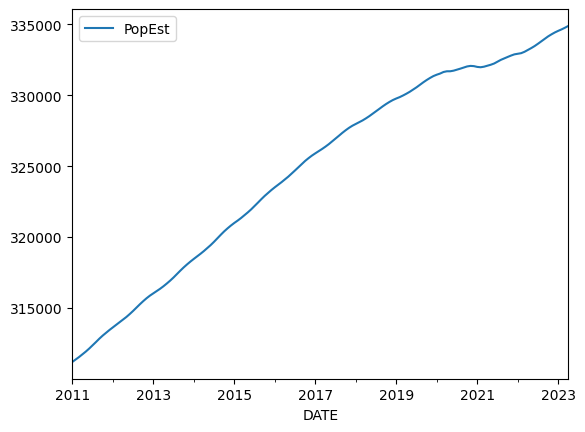

In [88]:
df.plot()


<Axes: xlabel='DATE'>

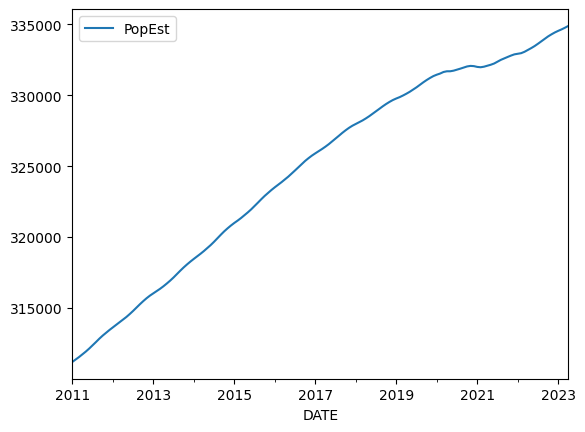

In [89]:
df.plot()
# from the plot we can see that it is quite linear although there is a bit of seasonality
# thus, the AR model should work well on this data

In [90]:
len(df)

148

In [141]:
# use up to 2019
end = 148-(12*4+4)
end_train = end-12
df_raw = df.copy()
df = df.iloc[:end]
df.tail()


,PopEst
DATE,
2018-08-01,329040.0
2018-09-01,329216.0
2018-10-01,329379.0
2018-11-01,329527.0
2018-12-01,329659.0


In [142]:
train_data = df.iloc[:end_train]
test_data = df.iloc[end_train:]

### calculate the best number of lags to be used by AR model
* lags i.e. parameter p
* glob=True: This parameter specifies whether to use a global search for determining the best order. 
    * If glob is set to True, the function will perform an exhaustive search over all possible orders up to the maxlag parameter. 
    * If False, a stepwise search will be performed to find the best order. In this case, a global search is conducted.
    * Forward Selection: This method starts with an empty model and adds predictors one at a time based on a pre-defined criterion, such as the improvement in the model's fit (e.g., decrease in the residual sum of squares). It continues adding predictors until no further improvement is observed.
    * Backward Elimination: This method starts with a model containing all predictors and removes them one at a time based on a pre-defined criterion, such as the least significant improvement in the model's fit (e.g., smallest increase in the residual sum of squares). It continues removing predictors until no further improvement is observed.
* in our case the model with p=14 has better AIC compared to model with p=8 although p=8 has lower RMSE error in predicting test data

In [143]:
ar_order = ar_select_order(train_data['PopEst'], maxlag=8, ic='aic', glob=False).ar_lags
# ar_order_aic_glob = ar_select_order(train_data['PopEst'], maxlag=16, ic='aic', glob=True).ar_lags
ar_order_aic_glob = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16]
# ar_order_bic_glob = ar_select_order(train_data['PopEst'], maxlag=16, ic='bic', glob=True).ar_lags
ar_order_bic_glob = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
print(ar_order)
print(ar_order_bic_glob)
print(ar_order_aic_glob)

# ar_order = [1, 2, 3, 4, 5, 6, 7, 8]
# # Result with bic
# ar_order_bic_glob = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
# glob=false [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# # Result with aic
# ar_order_aic_glob = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16]

[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16]


In [144]:
# model = ARIMA(train['PopEst'], freq='MS')
model_autoreg_1 = AutoReg(train_data['PopEst'], lags=[1]).fit()
model_autoreg_best = AutoReg(train_data['PopEst'], lags=ar_order).fit()
model_autoreg_aic_glob = AutoReg(train_data['PopEst'], lags=ar_order_aic_glob).fit()
model_autoreg_bic_glob = AutoReg(train_data['PopEst'], lags=ar_order_bic_glob).fit()

In [145]:
print(model_autoreg_aic_glob.aic)
print(model_autoreg_bic_glob.aic)
print(model_autoreg_best.aic)

401.0912448913538
415.23435989864487
501.18109970582213


In [146]:
model_autoreg_1.params

const        444.798662
PopEst.L1      0.999236
dtype: float64

In [147]:
model_autoreg_aic_glob.params

const         91.280696
PopEst.L1      2.525470
PopEst.L2     -2.592764
PopEst.L3      2.001459
PopEst.L4     -1.968397
PopEst.L5      2.134737
PopEst.L6     -2.253754
PopEst.L7      2.215040
PopEst.L8     -1.885551
PopEst.L9      1.715246
PopEst.L10    -1.967507
PopEst.L11     2.222401
PopEst.L12    -1.557299
PopEst.L13     0.376371
PopEst.L16     0.034263
dtype: float64

In [148]:
model_autoreg_best.params

const        92.205382
PopEst.L1     2.473036
PopEst.L2    -2.342741
PopEst.L3     1.689512
PopEst.L4    -1.844142
PopEst.L5     1.725060
PopEst.L6    -1.360013
PopEst.L7     1.153622
PopEst.L8    -0.494585
dtype: float64

#### store the start and end of test data index


In [149]:
start = len(train_data)
end = len(train_data)+len(test_data)-1

In [150]:
predictions1 = model_autoreg_1.predict(start=start, end=end)
predictions1 = pd.DataFrame(data=predictions1, columns=['AR(1) Predictions'])

In [151]:
p = len(ar_order)
predictions_best = model_autoreg_best.predict(start=start, end=end)
predictions_best = pd.DataFrame(data=predictions_best, columns=[f'AR({p}) Predictions'])

In [152]:
p_aic = len(ar_order_aic_glob)
predictions_aic_glob = model_autoreg_aic_glob.predict(start=start, end=end)
predictions_aic_glob = pd.DataFrame(data=predictions_aic_glob, columns=[f'AR({p_aic}) Predictions AIC'])

In [153]:
p_bic = len(ar_order_bic_glob)
predictions_bic_glob = model_autoreg_bic_glob.predict(start=start, end=end)
predictions_bic_glob = pd.DataFrame(data=predictions_bic_glob, columns=[f'AR({p_bic}) Predictions BIC'])

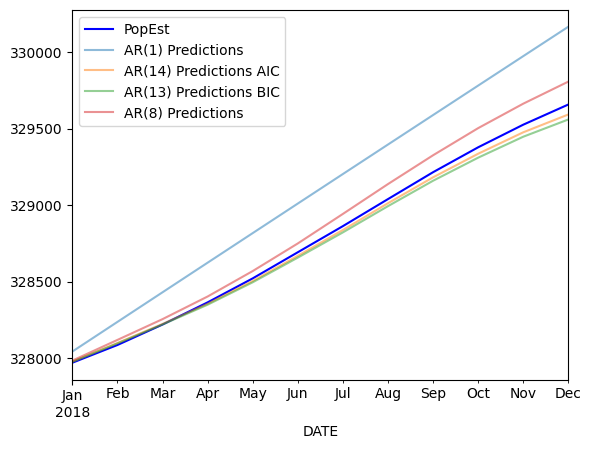

In [154]:
# test_data['PopEst'].plot(legend=True, label='TEST')
# predictions1['AR(1) Predictions'].plot(legend=True);
# predictions_best['AR(14) Predictions'].plot(legend=True);
ax = test_data.plot(legend=True, c='blue')
predictions1.plot(ax=ax, legend=True, alpha=0.5);
predictions_aic_glob.plot(ax=ax, legend=True, alpha=0.5);
predictions_bic_glob.plot(ax=ax, legend=True, alpha=0.5);
predictions_best.plot(ax=ax, legend=True, alpha=0.5);

### Calculate the error of the models

In [155]:
from sklearn.metrics import mean_squared_error
labels = ['AR(1)', f'AR({p_aic}) AIC', f'AR({p_bic}) BIC', f'AR({p}) Best', ]
predictions = [predictions1, predictions_aic_glob, predictions_bic_glob, predictions_best]

In [156]:
for i in range(len(predictions)):
    # np.sqrt() to take out the square if you want
    error = mean_squared_error(y_true=test_data['PopEst'], y_pred=predictions[i].iloc[:,0])
    print(f'{labels[i]} RMSE = {np.sqrt(error)}')
# surprisengly, manually setting p to 8 which has higher AIC than AR(6) turns out to be better at predicting

AR(1) RMSE = 333.7950320323743
AR(14) AIC RMSE = 31.853295488253586
AR(13) BIC RMSE = 49.66866132180906
AR(8) Best RMSE = 89.02773138851802


### Let us look at the fitted values and check which method fits training data better

##### Each model cuts some first portion of the training data in the fitted result, Why!?

In [157]:
print(model_autoreg_best.fittedvalues.shape)
print(model_autoreg_aic_glob.fittedvalues.shape)
print(model_autoreg_bic_glob.fittedvalues.shape)
print(train_data['PopEst'].shape)

(76,)
(68,)
(70,)
(84,)


In [158]:
print(model_autoreg_best.fittedvalues.index[0])
print(model_autoreg_aic_glob.fittedvalues.index[0])
print(model_autoreg_bic_glob.fittedvalues.index[0])

2011-09-01 00:00:00
2012-05-01 00:00:00
2012-03-01 00:00:00


<Axes: xlabel='DATE'>

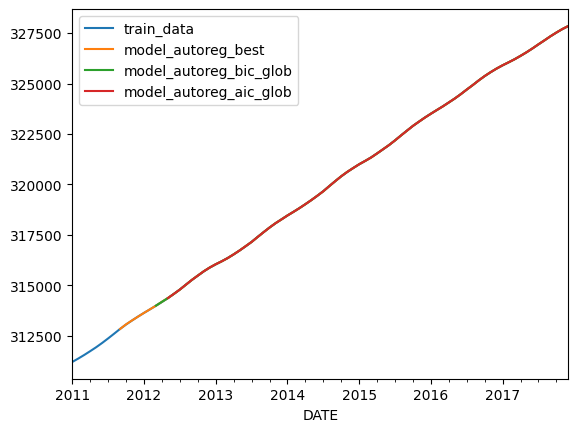

In [159]:
train_data['PopEst'].plot(legend=True, label = 'train_data')
model_autoreg_best.fittedvalues.plot(legend=True, label = 'model_autoreg_best')
model_autoreg_bic_glob.fittedvalues.plot(legend=True, label = 'model_autoreg_bic_glob')
model_autoreg_aic_glob.fittedvalues.plot(legend=True, label = 'model_autoreg_aic_glob')

In [160]:
labels = [f'AR({p_aic}) AIC', f'AR({p_bic}) BIC', f'AR({p})', ]
models = [model_autoreg_aic_glob, model_autoreg_bic_glob, model_autoreg_best ]
for i in range(len(models)):
    error = mean_squared_error(y_true=train_data['PopEst'].loc[models[i].fittedvalues.index[0]:], y_pred=models[i].fittedvalues.loc[models[i].fittedvalues.index[0]:])
    print(f'{labels[i]} RMSE = {np.sqrt(error)}')

AR(14) AIC RMSE = 3.650877973053472
AR(13) BIC RMSE = 3.791400462725363
AR(8) RMSE = 5.7357963362758255


### Retrain on whole data and Predict actual future

In [172]:
model_autoreg_best_whole = AutoReg(df['PopEst'], lags=ar_order).fit()
predictions_to_future = model_autoreg_best_whole.predict(start=end, end=end+12)

In [173]:
df.tail()

,PopEst
DATE,
2018-08-01,329040.0
2018-09-01,329216.0
2018-10-01,329379.0
2018-11-01,329527.0
2018-12-01,329659.0


In [174]:
predictions_to_future

2018-12-01    329660.126823
2019-01-01    329782.463345
2019-02-01    329904.762409
2019-03-01    330028.911883
2019-04-01    330163.029261
2019-05-01    330310.404376
2019-06-01    330468.134806
2019-07-01    330633.004792
2019-08-01    330798.013533
2019-09-01    330956.913557
2019-10-01    331106.043559
2019-11-01    331242.428913
2019-12-01    331367.937332
Freq: MS, dtype: float64

In [175]:
df_raw.iloc[end:end+13,0]

DATE
2018-12-01    329659.0
2019-01-01    329766.0
2019-02-01    329862.0
2019-03-01    329977.0
2019-04-01    330103.0
2019-05-01    330240.0
2019-06-01    330393.0
2019-07-01    330553.0
2019-08-01    330729.0
2019-09-01    330904.0
2019-10-01    331066.0
2019-11-01    331213.0
2019-12-01    331345.0
Freq: MS, Name: PopEst, dtype: float64

In [176]:
# AR(1) RMSE = 287.07570176735663
# AR(14) AIC RMSE = 32.50337180239136
# AR(13) BIC RMSE = 27.087672330609188
# AR(8) Best RMSE = 54.74119740629189
### FUTURE
# AR(14) AIC RMSE = 31.283633174980974
# AR(13) BIC RMSE = 26.096703164744056
# AR(8) Best RMSE = 52.59456980709519
df_raw
error = np.sqrt(mean_squared_error(y_true=df_raw.iloc[end:end+13,0], y_pred=predictions_to_future))
error

52.59456980709519

AR(14) AIC RMSE = 31.283633174980974
AR(13) BIC RMSE = 26.096703164744056
AR(8) Best RMSE = 52.59456980709519


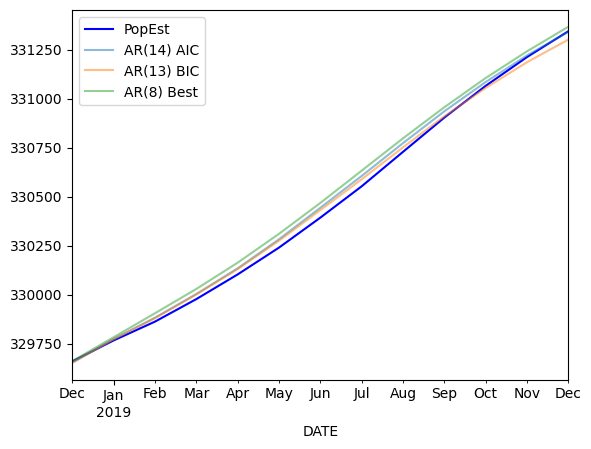

In [185]:
orders = [ar_order_aic_glob, ar_order_bic_glob, ar_order]
labels = ['AR(14) AIC', 'AR(13) BIC', 'AR(8) Best']
ax = df_raw.iloc[end:end+13,0].plot(legend=True, c='blue')
for i in range(len(orders)):
    md = AutoReg(df['PopEst'], lags=orders[i]).fit()
    future = md.predict(start=end, end=end+12)
    future.plot(ax=ax, legend=True, alpha=0.5, label=labels[i]);
    error = mean_squared_error(y_true=df_raw.iloc[end:end+13,0], y_pred=future)
    print(f'{labels[i]} RMSE = {np.sqrt(error)}')